In [1]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt

date1 = input("動的実験の日付を入力してください: ")

動的実験の日付を入力してください:  20231207


In [2]:
date2 = input("静的実験の日付を入力してください: ")

静的実験の日付を入力してください:  20231124


In [4]:
count2 = input("静的実験の測定回数を入力してください(例:1): ") 

静的実験の測定回数を入力してください(例:1):  5


In [5]:
measurement_kind = input("マッキベンの種類を入力してください(4s or 4l or 6 or s or u): ")  

マッキベンの種類を入力してください(4s or 4l or 6 or s or u):  4s


動的実験の測定回数を入力してください(例:1):  1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


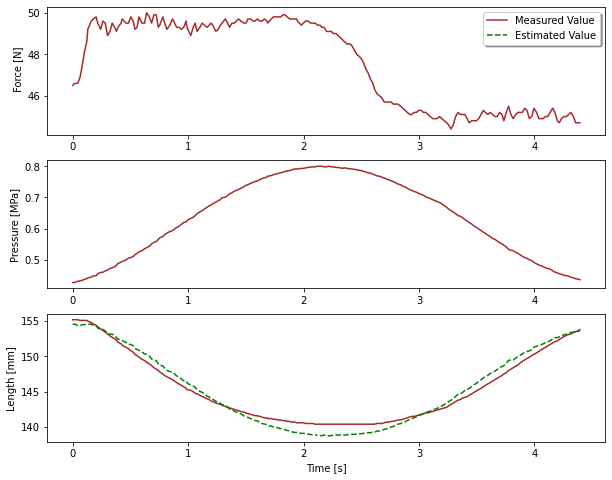

In [14]:
count = input("動的実験の測定回数を入力してください(例:1): ") 

file_path = f"C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\pressure_control\\output\\{date1}_{count}_{measurement_kind}_0.6_partial_p_output_3d_by_{count2}.csv"
df = pd.read_csv(file_path)


file_path = f"C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\estimated_parameter_2d_ieeesensors\\{date2}_{count2}_{measurement_kind}_2d_ieeesensors(1).csv"
df_parameters = pd.read_csv(file_path, index_col=0)

fit_params_path = 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\length_pressure\\fit_params.csv'
fit_params = pd.read_csv(fit_params_path, index_col=0)


c3, c2, c1, c0 = df_parameters.loc[['c3', 'c2', 'c1', 'c0']].values

# 定数 A, B の値を measurement_kind に基づいて設定
if measurement_kind == '6':
    constant_A, constant_B = 19, 34
elif measurement_kind == '4s':
    constant_A, constant_B = 10, 27
elif measurement_kind == '4ss':
    constant_A, constant_B = 16, 33
elif measurement_kind == 's':
    constant_A, constant_B = 25,36
else:
    # デフォルト値またはエラーハンドリングが必要な場合に設定してください
    constant_A, constant_B = 0, 0  # デフォルト値として0を設定

#以下L_uの推定
parameter_mapping = {'6': 'PAM-A', '4s': 'PAM-B', '4ss': 'PAM-C', 's': 'PAM-D'}
selected_parameter = parameter_mapping.get(measurement_kind.lower())
selected_slope = fit_params.loc[selected_parameter, 'Slope']
selected_intercept = fit_params.loc[selected_parameter, 'Intercept']

# Pressure Contraction および Force Contraction が空白でない場合の計算
mask_contraction = (df['pressure_contraction'].notnull()) & (df['force_contraction'].notnull())
if mask_contraction.any():
    df_contraction = df[mask_contraction]

    def calculate_lengths_contraction(row):
        P = row['pressure_contraction']
        F = row['force_contraction']
        L_solution = fsolve(lambda L:c3*P*L**2+c2*P*L+c1*L**2+c0*L - F, 21.0)
        return L_solution[0] if L_solution[0] > 0 else np.nan

    df.loc[mask_contraction, 'Estimated_Stretched_Length_Contraction'] = df_contraction.apply(calculate_lengths_contraction, axis=1)

    # Unstretched Length の計算
    df.loc[mask_contraction, 'Estimated_Unstretched_Length_Contraction'] = (
        selected_slope * df_contraction['pressure_contraction'] + selected_intercept
    )

# Pressure Extension および Force Extension が空白でない場合の計算
mask_extension = (df['pressure_extension'].notnull()) & (df['force_extension'].notnull())
if mask_extension.any():
    df_extension = df[mask_extension]

    def calculate_lengths_extension(row):
        P = row['pressure_extension']
        F = row['force_extension']
        L_solution = fsolve(lambda L: c3*P*L**2+c2*P*L+c1*L**2+c0*L - F, 16.0)
        return L_solution[0] if L_solution[0] > 0 else np.nan

    df.loc[mask_extension, 'Estimated_Stretched_Length_Extension'] = df_extension.apply(calculate_lengths_extension, axis=1)

    # Unstretched Length の計算
    df.loc[mask_extension, 'Estimated_Unstretched_Length_Extension'] = (
        selected_slope * df_extension['pressure_extension'] + selected_intercept
    )

# Estimated Length 列の計算
df['Estimated_Length_Contraction'] = df['Estimated_Stretched_Length_Contraction'] + df['Estimated_Unstretched_Length_Contraction']
df['Estimated_Length_Extension'] = df['Estimated_Stretched_Length_Extension'] + df['Estimated_Unstretched_Length_Extension']
   
    
df['real_length_contraction'] = df['length_contraction'] - constant_B
df['Real_Estimated_Length_Contraction'] = df['Estimated_Length_Contraction'] - constant_A
df['real_length_extension'] = df['length_extension'] - constant_B
df['Real_Estimated_Length_Extension'] = df['Estimated_Length_Extension'] - constant_A

df['real_length'] = df['real_length_contraction'].combine_first(df['real_length_extension'])
df['time_elapsed'] = df['time_contraction'].combine_first(df['time_extension'])


result_path = f'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\estimated_L_for_dynamic_experiment_2d_ieeesensors\\{date1}_{count}_{measurement_kind}_by_{count2}_L_estimation_2d_ieeesensors(1).csv'
df.to_csv(result_path, index=False)

column = df[["time", "length", "pressure", "force",'time_elapsed','time_contraction','time_extension',"estimated_contraction_length","estimated_extension_length","Real_Estimated_Length_Contraction","real_length","Real_Estimated_Length_Extension"]]

time_values = column['time_elapsed'].values
pressure_values = column["pressure"].values
length_values = column["length"].values
force_values = column["force"].values
time_contraction = column["time_contraction"].values
time_extension = column["time_extension"].values
real_length = column["real_length"]
Real_Estimated_Length_Contraction = column["Real_Estimated_Length_Contraction"]
Real_Estimated_Length_Extension = column["Real_Estimated_Length_Extension"]


# センサー値グラフ
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True)
plt.plot(time_values, force_values, color='brown', label='Measured Value')
# ダミーのプロットでEstimated Valueを追加（透明にする）
plt.plot([], [], color='green', linestyle='--', label='Estimated Value')
plt.ylabel(' Force [N]')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True)


plt.subplot(3, 1, 2)
plt.plot(time_values, pressure_values, color='brown', label='Measured Value')
plt.ylabel('Pressure [MPa]')

plt.subplot(3, 1, 3)
plt.plot(time_values, real_length,color='brown', label='Measured Value')
plt.plot(time_contraction, Real_Estimated_Length_Contraction, '--', color='green', label='Estimated Value')
plt.plot(time_extension, Real_Estimated_Length_Extension, '--', color='green')
plt.xlabel('Time [s]')
plt.ylabel('Length [mm]')

# グラフ全体の凡例を追加
#handles, labels = plt.gca().get_legend_handles_labels()
#plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.74, 0.1), ncol=5, fancybox=True, shadow=True)

# グラフ全体の凡例を追加
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.figlegend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.1), ncol=1, fancybox=True, shadow=True)

# グラフを保存

file_name_partial_com15 = f"{date1}_{count}_{measurement_kind}"
save_path_com15 = 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\graph\\estimated_L_for_dynamic_experiment_2d_ieeesensors\\'
plt.savefig(save_path_com15 + file_name_partial_com15 + f"_by_{count2}_2d_ieeesensors(1).pdf",bbox_inches='tight')

# グラフを表示
plt.show()
